In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production solaire** :

* SARIMAX avec des fonctions sinusoïdales correspondant aux saisons observées en régresseurs exogènes
* SARIMAX avec des données métier en régresseurs exogènes (soleil).
* SARIMAX avec des données métier FILTREES en régresseurs exogènes
* SARIMAX sur le signal filtré par transformation de Fourier sans régresseur
* SARIMAX sur le signal filtré avec des données métier FILTREES en régresseurs exogènes
* Régression linéaire sur les données métiers FILTREES comme variables explicatives
* Régression linéaire sur la variable à expliquée FILTREE et avec les variables explicatives FILTREES.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_D.csv',
                usecols = ['Dates', 'Solaire'])
df.head(1)

,Dates,Solaire
0,2013-01-01,117.333333


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [5]:
capa = pd.read_csv('./datasource/capacite_solaire_FR.csv',
                  usecols = ['Dates', 'Capa_sol'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [6]:
capa = capa.resample('D').mean()

In [7]:
df = pd.concat([df, capa], axis = 1)
df['TCH_sol'] = df['Solaire'] / df['Capa_sol']
df

,Solaire,Capa_sol,TCH_sol
Dates,,,
2013-01-01,117.333333,3644,0.032199
2013-01-02,262.770833,3647,0.072051
2013-01-03,210.729167,3648,0.057766
2013-01-04,141.729167,3649,0.038841
2013-01-05,149.979167,3650,0.041090
...,...,...,...
2021-10-27,1797.666667,12437,0.144542
2021-10-28,1764.812500,12444,0.141820
2021-10-29,880.541667,12454,0.070704


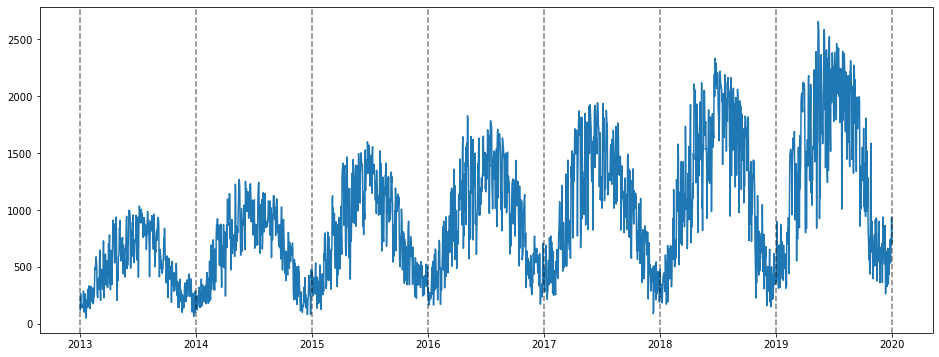

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df['Solaire'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

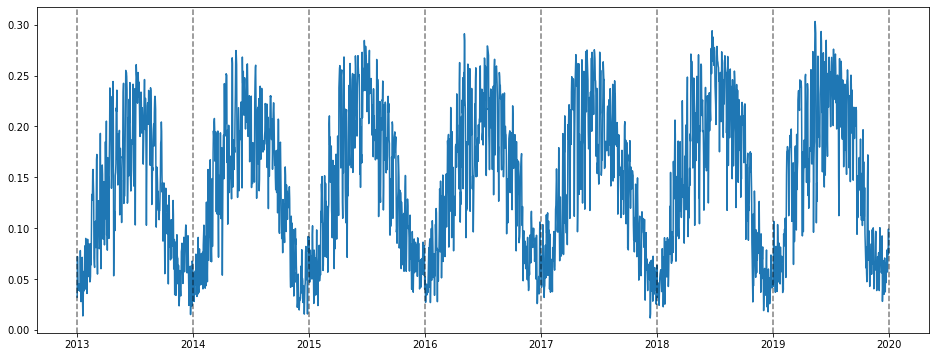

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_sol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

### Test de stationnarité

In [10]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_sol'])

(-3.9606086515758063,
 0.001631418412006807,
 14,
 3211,
 {'1%': -3.432388161120837,
  '5%': -2.862440536429695,
  '10%': -2.5672493755233123},
 -12799.62118628942)

### Coéfficients SARIMAX et saisonnalités

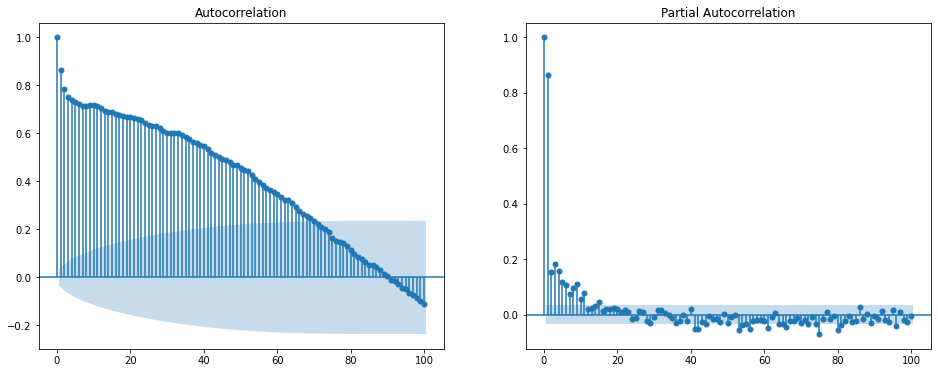

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_sol'], lags = 100, ax=ax1)
plot_pacf(df['TCH_sol'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 1 an

# Import du dataset filtré (Transformation de Fourier)

In [12]:
df_filtered = pd.read_csv('./dataset/France_D_filtered.csv',
                usecols = ['Dates', 'Solaire'])
df_filtered.head(1)

,Dates,Solaire
0,2013-01-01,185.528466


In [13]:
df_filtered['Dates'] = pd.to_datetime(df_filtered['Dates'], yearfirst = True)
df_filtered.set_index('Dates', inplace = True)

In [14]:
df_filtered = pd.concat([df_filtered, capa], axis = 1)
df_filtered['TCH_sol'] = df_filtered['Solaire'] / df_filtered['Capa_sol']

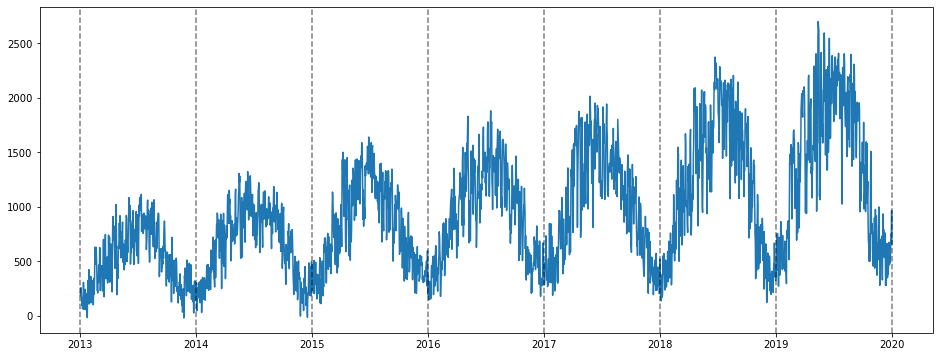

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['Solaire'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

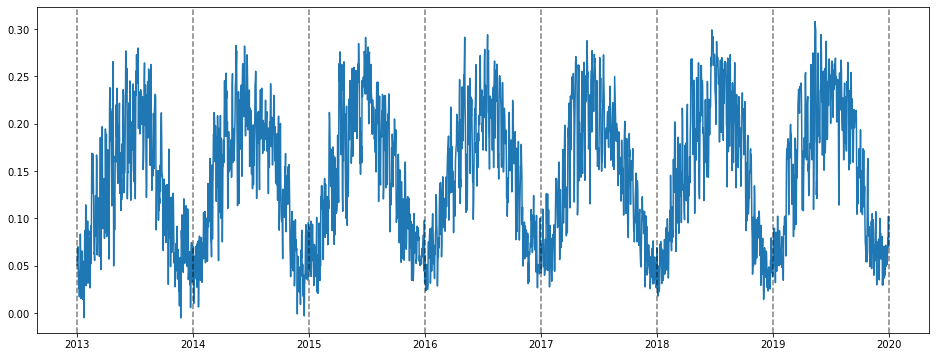

In [16]:
plt.figure(figsize=(16, 6))
plt.plot(df_filtered['TCH_sol'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5);

# Jeux d'entrainement et de test

In [17]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [18]:
df_train_filter = df_filtered[(df_filtered.index >= debut) & (df_filtered.index < fin)]
df_test_filter = df_filtered[df_filtered.index >= fin]

In [19]:
fenetre = df_test.shape[0]

In [20]:
indice = df_test.index

In [21]:
bilan = df_test

# Paramètres SARIMAX

In [22]:
ordre = (2,0,0)
saison = (0,0,0,365)

# Régresseurs exogènes : sinus & cosinus suivant les saisonnalités

In [23]:
exog = pd.DataFrame({'date': df.index})
exog['date'] = pd.to_datetime(exog['date'])
# suivant saisonnalités
# exog['sin_D'] = np.sin(2 * np.pi * exog.index / 8)
# exog['cos_D'] = np.cos(2 * np.pi * exog.index / 8)
# exog['sin_W'] = np.sin(2 * np.pi * exog.index / 7)
# exog['cos_W'] = np.cos(2 * np.pi * exog.index / 7)
exog['sin_Y'] = np.sin(2 * np.pi * exog.index / 365.25)
exog['cos_Y'] = np.cos(2 * np.pi * exog.index / 365.25)
exog.set_index('date', inplace = True)

In [24]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

<ipython-input-25-56416ee0eedf>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])


''

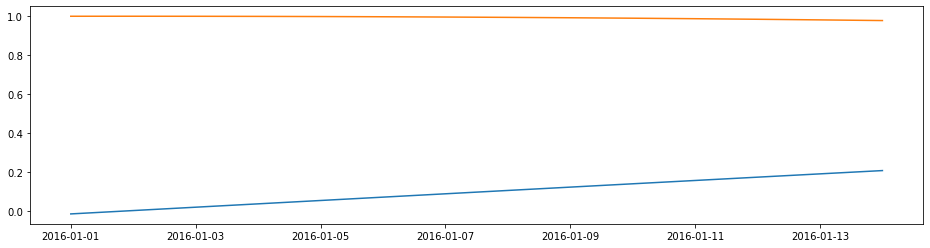

In [25]:
plt.figure(figsize=(16, 4))
plt.plot(exog[(exog.index >= pd.datetime(2016, 1, 1)) & (exog.index < pd.datetime(2016, 1, 15))])
# for year in range(debut.year, fin.year + 1): 
#     plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### SARIMAX

In [26]:
model_sinus = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                             exog = exog_train.values,
                             order = ordre,
                             seasonal_order = saison)
result_sinus = model_sinus.fit()

In [27]:
predict_sinus = result_sinus.predict(start = 1 ,
                                     end = fenetre,
                                     exog = exog_test.values)

In [28]:
predict_sinus = pd.DataFrame(predict_sinus, columns=['Sol_p_sinus'], index = indice)

In [29]:
bilan = pd.concat([bilan, predict_sinus], axis = 1)

### Erreur absolue

In [30]:
bilan['Err_sinus'] = np.abs(bilan['Sol_p_sinus'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,0.139356,0.040357
std,724.919423,894.312023,0.066439,0.062326,0.032086
min,255.875000,9414.000000,0.025042,0.015181,0.000262
25%,918.302083,9791.500000,0.091626,0.084123,0.015716
50%,1627.468750,10167.000000,0.150289,0.144025,0.031499
75%,2179.276042,11239.250000,0.202966,0.189270,0.058284
max,3141.270833,12469.000000,0.276460,0.268618,0.157188


# Régresseurs exogènes : données métier

In [31]:
exog = pd.read_csv('./exog/exog_D_FR.csv', sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01,8.05


In [32]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [33]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [34]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [35]:
result_exog = model_exog.fit(low_memory=True)

In [36]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5074.954
Date:                Wed, 04 May 2022   AIC                         -10141.909
Time:                        10:28:30   BIC                         -10118.524
Sample:                             0   HQIC                        -10133.428
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0123      0.000     72.267      0.000       0.012       0.013
ar.L1          0.6307      0.020     31.948      0.000       0.592       0.669
ar.L2          0.0630      0.020      3.192      0.001       0.024       0.102
sigma2         0.0011   3.09e-05     35.756      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                47.10
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.20
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [37]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [38]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Sol_p_exog'])

In [39]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [40]:
bilan['Err_exog'] = np.abs(bilan['Sol_p_exog'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,0.139356,0.040357,0.146329,0.036737
std,724.919423,894.312023,0.066439,0.062326,0.032086,0.053014,0.028004
min,255.875000,9414.000000,0.025042,0.015181,0.000262,0.043373,0.000017
25%,918.302083,9791.500000,0.091626,0.084123,0.015716,0.098320,0.015730
50%,1627.468750,10167.000000,0.150289,0.144025,0.031499,0.153369,0.030610
75%,2179.276042,11239.250000,0.202966,0.189270,0.058284,0.188037,0.051504
max,3141.270833,12469.000000,0.276460,0.268618,0.157188,0.249077,0.137647


# Régresseurs exogènes : données métier FILTREES

In [41]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01,8.05


In [42]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [43]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [44]:
model_filter = sm.tsa.SARIMAX(df_train['TCH_sol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [45]:
result_filter = model_filter.fit(low_memory=True)

In [46]:
result_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5074.954
Date:                Wed, 04 May 2022   AIC                         -10141.909
Time:                        10:28:31   BIC                         -10118.524
Sample:                             0   HQIC                        -10133.428
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0123      0.000     72.267      0.000       0.012       0.013
ar.L1          0.6307      0.020     31.948      0.000       0.592       0.669
ar.L2          0.0630      0.020      3.192      0.001       0.024       0.102
sigma2         0.0011   3.09e-05     35.756      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                47.10
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -0.20
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [47]:
predict_filter = result_filter.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [48]:
predict_filter = pd.DataFrame(predict_filter, index = indice, columns = ['Sol_p_filter'])

In [49]:
bilan = pd.concat([bilan, predict_filter], axis = 1)

### Erreur absolue

In [50]:
bilan['Err_exog_filter'] = np.abs(bilan['Sol_p_filter'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,0.139356,0.040357,0.146329,0.036737,0.146329,0.036737
std,724.919423,894.312023,0.066439,0.062326,0.032086,0.053014,0.028004,0.053014,0.028004
min,255.875000,9414.000000,0.025042,0.015181,0.000262,0.043373,0.000017,0.043373,0.000017
25%,918.302083,9791.500000,0.091626,0.084123,0.015716,0.098320,0.015730,0.098320,0.015730
50%,1627.468750,10167.000000,0.150289,0.144025,0.031499,0.153369,0.030610,0.153369,0.030610
75%,2179.276042,11239.250000,0.202966,0.189270,0.058284,0.188037,0.051504,0.188037,0.051504
max,3141.270833,12469.000000,0.276460,0.268618,0.157188,0.249077,0.137647,0.249077,0.137647


# Target FILTREE sans régresseur

### SARIMAX

In [51]:
model_reduit_noreg = sm.tsa.SARIMAX(df_train_filter['TCH_sol'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [52]:
result_reduit_noreg = model_reduit_noreg.fit(low_memory=True)

C:\Python\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
result_reduit_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5006.861
Date:                Wed, 04 May 2022   AIC                         -10007.722
Time:                        10:28:33   BIC                          -9990.184
Sample:                             0   HQIC                        -10001.362
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8239      0.020     42.190      0.000       0.786       0.862
ar.L2          0.1566      0.020      8.016      0.000       0.118       0.195
sigma2         0.0012   3.25e-05     35.758      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   5.14   Jarque-Bera (JB):                30.15
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [54]:
predict_reduit_noreg = result_reduit_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [55]:
predict_reduit_noreg = pd.DataFrame(predict_reduit_noreg, index = indice, columns = ['Sol_p_reduit_noreg'])

In [56]:
bilan = pd.concat([bilan, predict_reduit_noreg], axis = 1)

### Erreur absolue

In [57]:
bilan['Err_filter_noreg'] = np.abs(bilan['Sol_p_reduit_noreg'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,0.139356,0.040357,0.146329,0.036737,0.146329,0.036737,0.139736,0.041878
std,724.919423,894.312023,0.066439,0.062326,0.032086,0.053014,0.028004,0.053014,0.028004,0.062612,0.033132
min,255.875000,9414.000000,0.025042,0.015181,0.000262,0.043373,0.000017,0.043373,0.000017,0.002609,0.000004
25%,918.302083,9791.500000,0.091626,0.084123,0.015716,0.098320,0.015730,0.098320,0.015730,0.086090,0.014966
50%,1627.468750,10167.000000,0.150289,0.144025,0.031499,0.153369,0.030610,0.153369,0.030610,0.144538,0.035559
75%,2179.276042,11239.250000,0.202966,0.189270,0.058284,0.188037,0.051504,0.188037,0.051504,0.189924,0.059398
max,3141.270833,12469.000000,0.276460,0.268618,0.157188,0.249077,0.137647,0.249077,0.137647,0.271635,0.166974


# Target FILTREE avec Régresseurs exogènes : données métier FILTREES

In [58]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01,8.05


In [59]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [60]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [61]:
model_reduit = sm.tsa.SARIMAX(df_train_filter['TCH_sol'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [62]:
result_reduit = model_reduit.fit(low_memory=True)

In [63]:
result_reduit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2556
Model:               SARIMAX(2, 0, 0)   Log Likelihood                5172.430
Date:                Wed, 04 May 2022   AIC                         -10336.859
Time:                        10:28:35   BIC                         -10313.474
Sample:                             0   HQIC                        -10328.379
                               - 2556                                         
Covariance Type:               approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0123      0.000     72.925      0.000       0.012       0.013
ar.L1          0.6839      0.020     34.578      0.000       0.645       0.723
ar.L2          0.0185      0.020      0.937      0.349      -0.020       0.057
sigma2         0.0010   2.86e-05     35.740      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 4.49
Prob(Q):                              0.81   Prob(JB):                         0.11
Heteroskedasticity (H):               0.79   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [64]:
predict_reduit = result_reduit.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [65]:
predict_reduit = pd.DataFrame(predict_reduit, index = indice, columns = ['Sol_p_reduit'])

In [66]:
bilan = pd.concat([bilan, predict_reduit], axis = 1)

### Erreur absolue

In [67]:
bilan['Err_filter_exog_filter'] = np.abs(bilan['Sol_p_reduit'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,0.139356,0.040357,0.146329,0.036737,0.146329,0.036737,0.139736,0.041878,0.146254,0.038099
std,724.919423,894.312023,0.066439,0.062326,0.032086,0.053014,0.028004,0.053014,0.028004,0.062612,0.033132,0.054211,0.028885
min,255.875000,9414.000000,0.025042,0.015181,0.000262,0.043373,0.000017,0.043373,0.000017,0.002609,0.000004,0.028346,0.000015
25%,918.302083,9791.500000,0.091626,0.084123,0.015716,0.098320,0.015730,0.098320,0.015730,0.086090,0.014966,0.097948,0.015816
50%,1627.468750,10167.000000,0.150289,0.144025,0.031499,0.153369,0.030610,0.153369,0.030610,0.144538,0.035559,0.152207,0.032553
75%,2179.276042,11239.250000,0.202966,0.189270,0.058284,0.188037,0.051504,0.188037,0.051504,0.189924,0.059398,0.189386,0.052620
max,3141.270833,12469.000000,0.276460,0.268618,0.157188,0.249077,0.137647,0.249077,0.137647,0.271635,0.166974,0.257392,0.143960


# Régression linéaire avec Régresseurs exogènes : données métier FILTREES 

In [68]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01,8.05


In [69]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [70]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [71]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_sol'])
predict_lr = LinReg.predict(exog_test)

In [72]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Sol_p_LinReg'])

In [73]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [74]:
bilan['Err_LinReg'] = np.abs(bilan['Sol_p_LinReg'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter,Sol_p_LinReg,Err_LinReg
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,0.139356,0.040357,0.146329,0.036737,0.146329,0.036737,0.139736,0.041878,0.146254,0.038099,0.152264,0.031490
std,724.919423,894.312023,0.066439,0.062326,0.032086,0.053014,0.028004,0.053014,0.028004,0.062612,0.033132,0.054211,0.028885,0.056018,0.022565
min,255.875000,9414.000000,0.025042,0.015181,0.000262,0.043373,0.000017,0.043373,0.000017,0.002609,0.000004,0.028346,0.000015,0.058997,0.000086
25%,918.302083,9791.500000,0.091626,0.084123,0.015716,0.098320,0.015730,0.098320,0.015730,0.086090,0.014966,0.097948,0.015816,0.102912,0.013237
50%,1627.468750,10167.000000,0.150289,0.144025,0.031499,0.153369,0.030610,0.153369,0.030610,0.144538,0.035559,0.152207,0.032553,0.155642,0.028064
75%,2179.276042,11239.250000,0.202966,0.189270,0.058284,0.188037,0.051504,0.188037,0.051504,0.189924,0.059398,0.189386,0.052620,0.205545,0.045061
max,3141.270833,12469.000000,0.276460,0.268618,0.157188,0.249077,0.137647,0.249077,0.137647,0.271635,0.166974,0.257392,0.143960,0.230330,0.117329


# Régression linéaire sur target FILTREE avec Régresseurs exogènes : données métier FILTREES 

In [75]:
exog = pd.read_csv('./exog/exog_D_FR_filtered.csv',# sep = ';',
                   usecols = ['Dates', 'Soleil'])
exog.head(1)

,Dates,Soleil
0,2013-01-01,8.05


In [76]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [77]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [78]:
LinReg_filter = LinearRegression()
LinReg_filter.fit(exog_train, df_train_filter['TCH_sol'])
predict_lr_filter = LinReg_filter.predict(exog_test)

In [79]:
predict_lr_filter = pd.DataFrame(predict_lr_filter, index = indice, columns = ['Sol_p_LinReg_filter'])

In [80]:
bilan = pd.concat([bilan, predict_lr_filter], axis = 1)

### Erreur absolue

In [81]:
bilan['Err_LinReg_filter'] = np.abs(bilan['Sol_p_LinReg_filter'] - bilan['TCH_sol'])
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter,Sol_p_LinReg,Err_LinReg,Sol_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,0.139356,0.040357,0.146329,0.036737,0.146329,0.036737,0.139736,0.041878,0.146254,0.038099,0.152264,0.031490,0.152262,0.031490
std,724.919423,894.312023,0.066439,0.062326,0.032086,0.053014,0.028004,0.053014,0.028004,0.062612,0.033132,0.054211,0.028885,0.056018,0.022565,0.056020,0.022565
min,255.875000,9414.000000,0.025042,0.015181,0.000262,0.043373,0.000017,0.043373,0.000017,0.002609,0.000004,0.028346,0.000015,0.058997,0.000086,0.058992,0.000086
25%,918.302083,9791.500000,0.091626,0.084123,0.015716,0.098320,0.015730,0.098320,0.015730,0.086090,0.014966,0.097948,0.015816,0.102912,0.013237,0.102908,0.013239
50%,1627.468750,10167.000000,0.150289,0.144025,0.031499,0.153369,0.030610,0.153369,0.030610,0.144538,0.035559,0.152207,0.032553,0.155642,0.028064,0.155640,0.028066
75%,2179.276042,11239.250000,0.202966,0.189270,0.058284,0.188037,0.051504,0.188037,0.051504,0.189924,0.059398,0.189386,0.052620,0.205545,0.045061,0.205545,0.045060
max,3141.270833,12469.000000,0.276460,0.268618,0.157188,0.249077,0.137647,0.249077,0.137647,0.271635,0.166974,0.257392,0.143960,0.230330,0.117329,0.230331,0.117329


# Calcul de la prediction : TCH x Capacité

In [82]:
bilan['Sol_p_sinus'] = bilan['Sol_p_sinus'] * bilan['Capa_sol']
bilan['Err_sinus'] = bilan['Err_sinus'] * bilan['Capa_sol']
bilan['Sol_p_exog'] = bilan['Sol_p_exog'] * bilan['Capa_sol']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_sol']
bilan['Sol_p_filter'] = bilan['Sol_p_filter'] * bilan['Capa_sol']
bilan['Err_exog_filter'] = bilan['Err_exog_filter'] * bilan['Capa_sol']
bilan['Sol_p_reduit_noreg'] = bilan['Sol_p_reduit_noreg'] * bilan['Capa_sol']
bilan['Err_filter_noreg'] = bilan['Err_filter_noreg'] * bilan['Capa_sol']
bilan['Sol_p_reduit'] = bilan['Sol_p_reduit'] * bilan['Capa_sol']
bilan['Err_filter_exog_filter'] = bilan['Err_filter_exog_filter'] * bilan['Capa_sol']
bilan['Sol_p_LinReg'] = bilan['Sol_p_LinReg'] * bilan['Capa_sol']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_sol']
bilan['Sol_p_LinReg_filter'] = bilan['Sol_p_LinReg_filter'] * bilan['Capa_sol']
bilan['Err_LinReg_filter'] = bilan['Err_LinReg_filter'] * bilan['Capa_sol']
bilan.describe()

,Solaire,Capa_sol,TCH_sol,Sol_p_sinus,Err_sinus,Sol_p_exog,Err_exog,Sol_p_filter,Err_exog_filter,Sol_p_reduit_noreg,Err_filter_noreg,Sol_p_reduit,Err_filter_exog_filter,Sol_p_LinReg,Err_LinReg,Sol_p_LinReg_filter,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,1571.800218,10519.437313,0.148462,1482.980940,424.658760,1553.140524,387.242290,1553.140524,387.242290,1487.262948,440.486354,1552.528698,401.441335,1612.078546,333.127140,1612.059630,333.124817
std,724.919423,894.312023,0.066439,699.177690,338.770041,604.886562,296.454643,604.886562,296.454643,701.855706,348.709856,616.049287,305.354352,626.912654,243.069004,626.933460,243.071793
min,255.875000,9414.000000,0.025042,143.567352,2.970009,410.998665,0.160200,410.998665,0.160200,24.692548,0.041002,287.048117,0.147846,574.189849,0.958295,574.140172,0.958907
25%,918.302083,9791.500000,0.091626,853.872773,163.652391,1000.263467,163.818604,1000.263467,163.818604,845.295655,154.997375,988.575792,168.120288,1057.316694,135.834919,1057.282359,135.809870
50%,1627.468750,10167.000000,0.150289,1509.746464,332.109825,1594.069687,320.066480,1594.069687,320.066480,1492.351739,371.810848,1591.013668,337.191933,1646.633680,293.966403,1646.621465,293.948470
75%,2179.276042,11239.250000,0.202966,2038.959087,625.925646,2055.684665,534.385880,2055.684665,534.385880,2065.560969,619.595688,2059.988946,563.642672,2158.604094,480.479159,2158.598805,480.484316
max,3141.270833,12469.000000,0.276460,3015.770539,1764.749705,2805.438044,1545.365433,2805.438044,1545.365433,3055.496866,1798.622471,2940.183360,1616.235597,2651.408741,1139.146513,2651.421376,1139.148263


# Visualisation réel vs prédictions

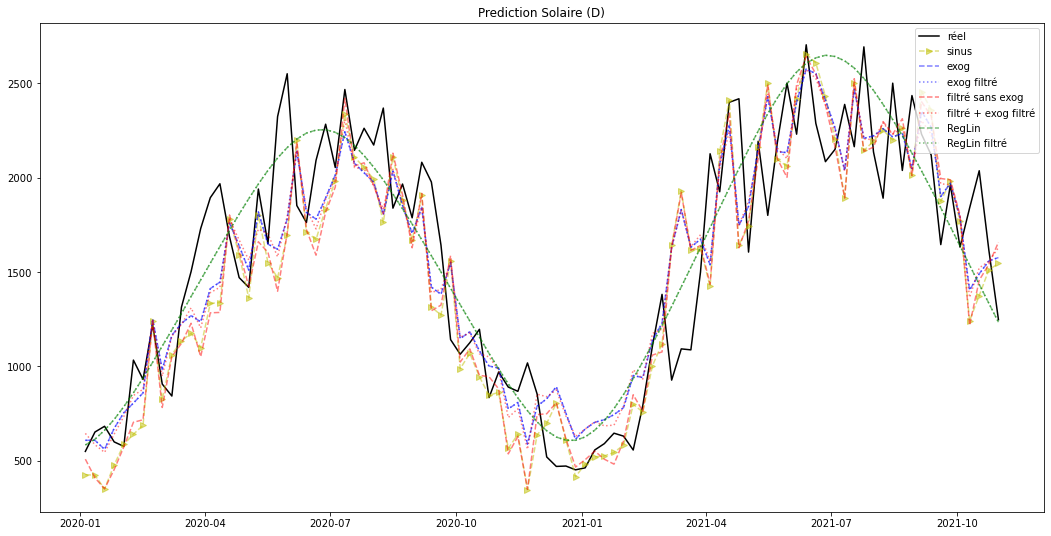

In [83]:
plt.figure(figsize=(18,9))
plt.plot(bilan['Solaire'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Sol_p_sinus'].resample('W').mean(), color = 'y', linestyle = '--', alpha = 0.5, label = 'sinus', marker = '>')
plt.plot(bilan['Sol_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Sol_p_filter'].resample('W').mean(), color = 'b', linestyle = ':', alpha = 0.5, label = 'exog filtré')
plt.plot(bilan['Sol_p_reduit_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Sol_p_reduit'].resample('W').mean(), color = 'r', linestyle = ':', alpha = 0.5, label = 'filtré + exog filtré')
plt.plot(bilan['Sol_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.plot(bilan['Sol_p_LinReg_filter'].resample('W').mean(), color = 'g', linestyle = ':', alpha = 0.5, label = 'RegLin filtré')
plt.legend(loc = 'upper right')
plt.title('Prediction Solaire (D)')
plt.savefig('./results/D/pred_solaire_D.png');

# Synthèse des erreurs

In [86]:
erreur = bilan[['Err_sinus',
       'Err_exog',
       'Err_exog_filter',
       'Err_filter_noreg',
       'Err_filter_exog_filter',
       'Err_LinReg',
       'Err_LinReg_filter'
      ]].describe()
erreur

,Err_sinus,Err_exog,Err_exog_filter,Err_filter_noreg,Err_filter_exog_filter,Err_LinReg,Err_LinReg_filter
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,424.658760,387.242290,387.242290,440.486354,401.441335,333.127140,333.124817
std,338.770041,296.454643,296.454643,348.709856,305.354352,243.069004,243.071793
min,2.970009,0.160200,0.160200,0.041002,0.147846,0.958295,0.958907
25%,163.652391,163.818604,163.818604,154.997375,168.120288,135.834919,135.809870
50%,332.109825,320.066480,320.066480,371.810848,337.191933,293.966403,293.948470
75%,625.925646,534.385880,534.385880,619.595688,563.642672,480.479159,480.484316
max,1764.749705,1545.365433,1545.365433,1798.622471,1616.235597,1139.146513,1139.148263


In [87]:
bilan.to_csv('./results/D/bilan_solaire_D.csv', sep = ';')
erreur.to_csv('./results/D/erreur_solaire_D.csv', sep = ';')